In [1]:
#part1
#importing the libraries
#loading the dataset
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.7.0'

In [2]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
projectpath ="/content/drive/MyDrive/greatlearningdata/train"

In [7]:
#1. import the dataset

In [8]:
#importing libraries
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray


In [9]:
# Loading the images file

dataset_file = '/content/drive/MyDrive/greatlearningdata/train/Part 1- Train data - images.npy'

In [10]:
data = np.load(dataset_file, allow_pickle=True)

In [11]:
#shape of the datset
data.shape

(409, 2)

From the above, it is clearly evident that the file contains 409 images and labels. Let's view few images and their labels.

In [12]:
data[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [13]:
data[408][1]

[{'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.3201219512195122, 'y': 0.2839756592292089},
   {'x': 0.4009146341463415, 'y': 0.4198782961460446}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.4557926829268293, 'y': 0.38742393509127787},
   {'x': 0.5442073170731707, 'y': 0.5618661257606491}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6707317073170732, 'y': 0.38336713995943206},
   {'x': 0.7134146341463414, 'y': 0.4746450304259635}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.16615853658536586, 'y': 0.4665314401622718},
   {'x': 0.22560975609756098, 'y': 0.563894523326572}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.07164634146341463, 'y': 0.539553752535497},
   {'x': 0.11280487804878049, 'y': 0.586206896551

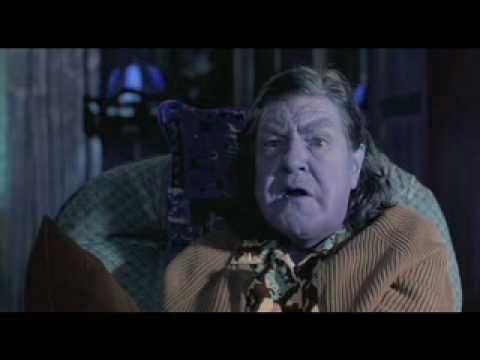

In [14]:
#displaying and veiwing few random images and labels of the dataset
from google.colab.patches import cv2_imshow

cv2_imshow(data[20][0])

The above image is a random image in the dataset

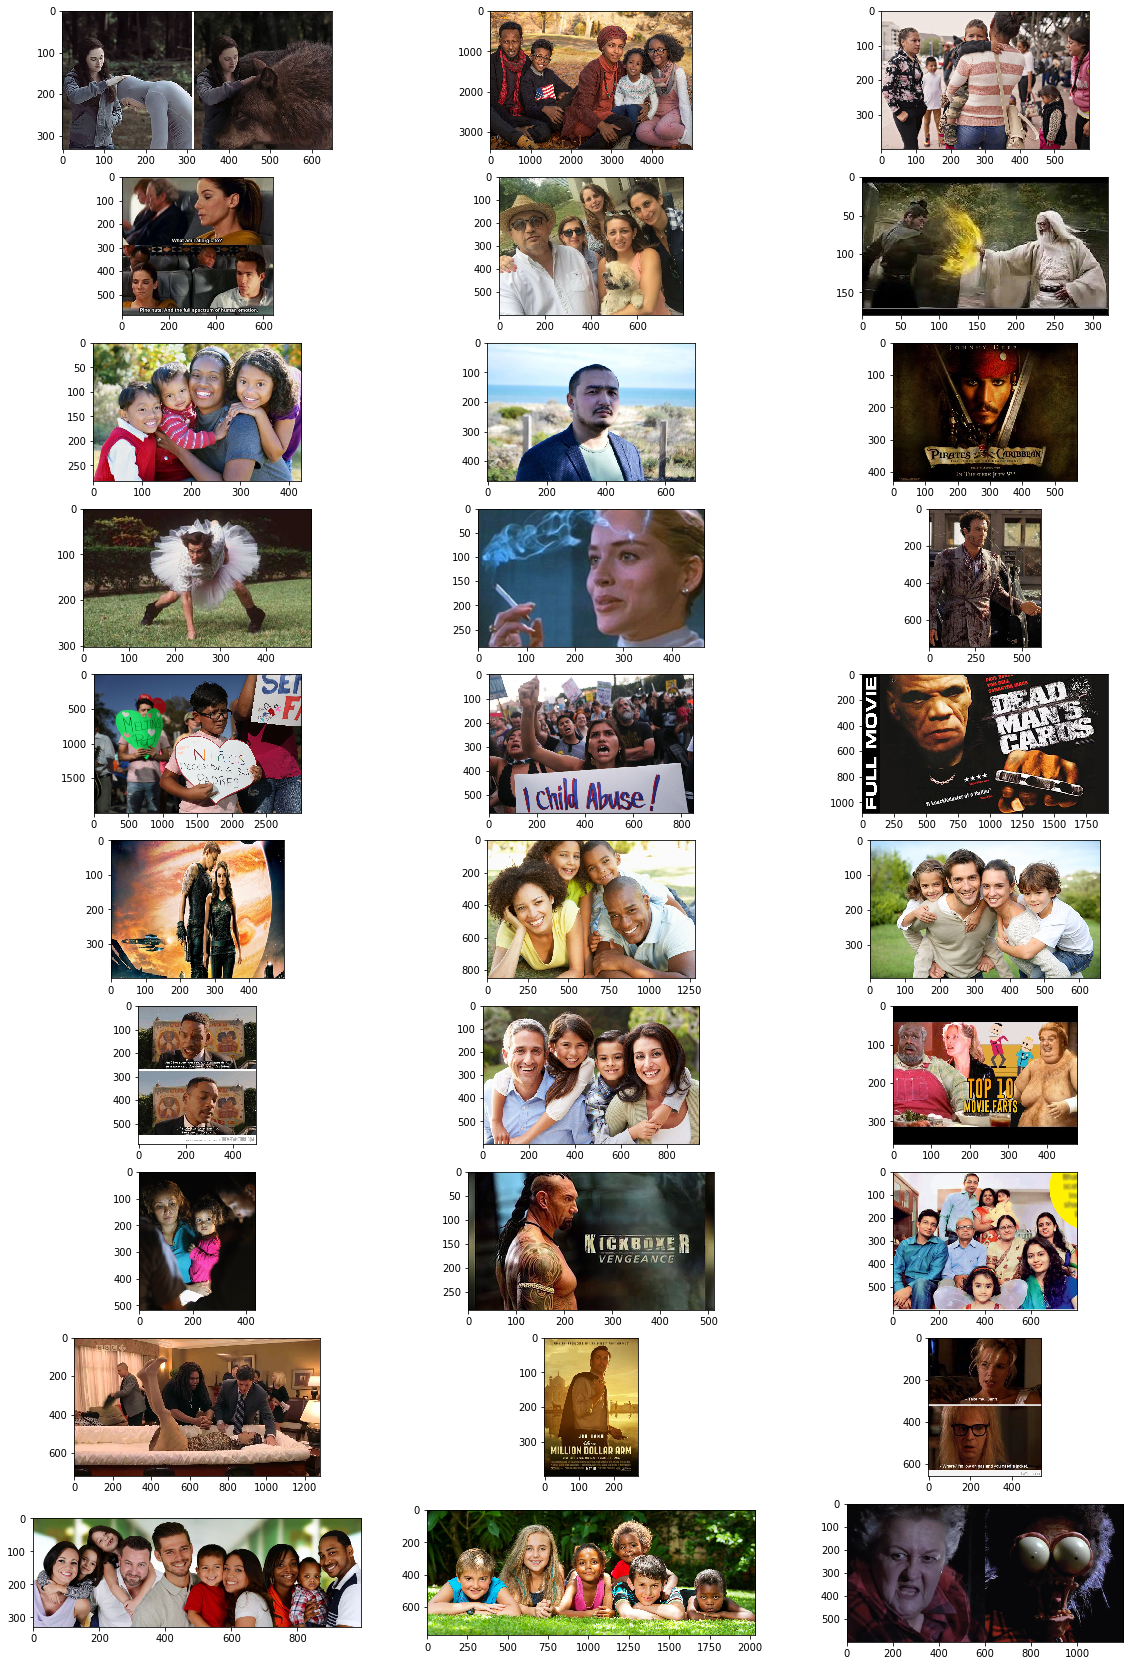

In [15]:
fi,ax_1 = plt.subplots(10,3,figsize=(20,30))
row_1 = 0
col_1 = 0
index_1 = 0
for i in range(30):
  ax_1[row_1][col_1].imshow(data[index_1][0], interpolation='nearest')
  index_1 = index_1 + 12
  col_1 = col_1 + 1
  if col_1 > 2:
    row_1 = row_1 + 1
    col_1 = 0
plt.show()


In [16]:
#2.Create features (images) and labels (mask) using that data.

In [17]:
from tensorflow.keras.applications.mobilenet import preprocess_input

image_h = 224 #image_h= height of the image
image_w= 224 #image_w= width of the image

h_c= 28 #h_c= height_cells
w_c= 28 #w_c= width_cells

image_size = 224 #image_size= size of the image

masks_1 = np.zeros((int(data.shape[0]),image_h, image_w))
X_1 = np.zeros((int(data.shape[0]),image_h, image_w, 3))

for index_1 in range(data.shape[0]):
  img_1 = data[index_1][0]
  img_1 = cv2.resize(img_1, dsize=(image_h,image_w), interpolation=cv2.INTER_CUBIC)
  # assign all the pixels in the first 3 channels only to the image.
  try:
    img_1 = img_1[:,:,:3]
  except:
    print(f"Exception {index_1} Grayscale image with shape {img_1.shape}")
    # convert the grayscale image to color so that the number of channels are standardized to 3
    img_1 = cv2.cvtColor(img_1, cv2.COLOR_GRAY2RGB)
    continue
  X_1[index_1] = preprocess_input(np.array(img_1, dtype=np.float32))
  # Looping through the face co-ordinates and then, creating a mask out of it.
  for i in data[index_1][1]:
    x1 = int(i['points'][0]['x'] * image_w)
    x2 = int(i['points'][1]['x'] * image_w)
    y1 = int(i['points'][0]['y'] * image_h)
    y2 = int(i['points'][1]['y'] * image_h)
    # setting all the pixels within the mask co-ordinates to 1.
    masks_1[index_1][y1:y2, x1:x2] = 1
print(f" Shape of X is '{X_1.shape}' and the shape of mask is '{masks_1.shape}' ")


Exception 272 Grayscale image with shape (224, 224)
 Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


In [18]:
#splitting the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_1, masks_1, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(327, 224, 224, 3)' and the shape of y_train is '(327, 224, 224)'
Shape of X_val is '(65, 224, 224, 3)' and the shape of y_val is '(65, 224, 224)'
Shape of X_test is '(17, 224, 224, 3)' and the shape of y_test is '(17, 224, 224)'


From, the above the shape of the training, testing, validation data set is determined

In [19]:
#visualizing few x_train and y_train images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


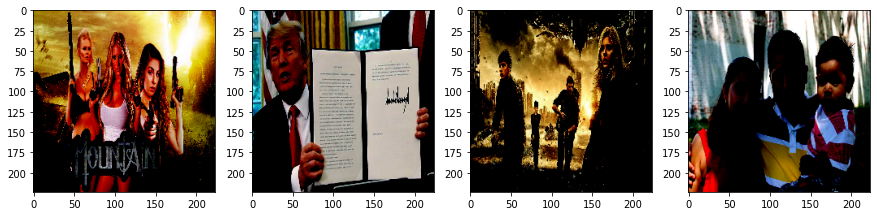

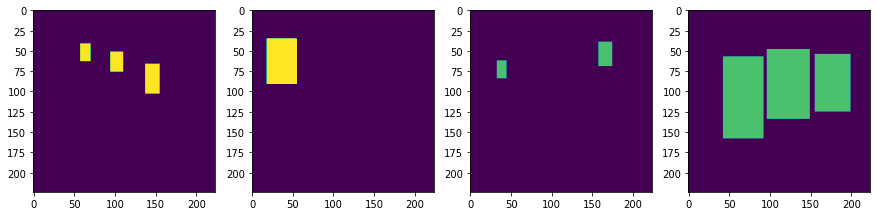

In [20]:
fig = plt.figure(figsize=(15, 15))
a1 = fig.add_subplot(1, 4, 1)
imgplot1 = plt.imshow(X_train[7])

a1 = fig.add_subplot(1, 4, 2)
imgplot1 = plt.imshow(X_train[15])
imgplot1.set_clim(0.0, 0.7)

a1 = fig.add_subplot(1, 4, 3)
imgplot1 = plt.imshow(X_train[20])
imgplot1.set_clim(0.0, 1.4)

a1 = fig.add_subplot(1, 4, 4)
imgplot1 = plt.imshow(X_train[30])
imgplot1.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a1 = fig.add_subplot(1, 4, 1)
imgplot1 = plt.imshow(y_train[7])

a1 = fig.add_subplot(1, 4, 2)
imgplot1 = plt.imshow(y_train[15])
imgplot1.set_clim(0.0, 0.7)

a1 = fig.add_subplot(1, 4, 3)
imgplot1 = plt.imshow(y_train[20])
imgplot1.set_clim(0.0, 1.4)

a1 = fig.add_subplot(1, 4, 4)
imgplot1 = plt.imshow(y_train[30])
imgplot1.set_clim(0.0, 1.4)


In [21]:
# 3.Mask detection model
  #1.Design a face mask detection model. Hint: Use U-net along with pre-trained transfer learning models

In [22]:
#defining the size of the image , epochs, batch size and learning rate of the image
size_i = 224
no_epochs1 = 20
batch1 = 10
learning_rate1= 1e-7

In [23]:
#defining the model using U-net along with a pre trained model mobile net.
def model():
    inputs_i = Input(shape=(size_i,size_i, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs_i, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_o = encoder.get_layer("block_13_expand_relu").output
    
    f_1 = [16, 32, 48, 64]
    x_2 = encoder_o
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip_1 = encoder.get_layer(skip_connection_names[-i]).output
        x_2 = UpSampling2D((2, 2))(x_2)
        x_2 = Concatenate()([x_2, x_skip_1])
        
        x_2 = Conv2D(f_1[-i], (3, 3), padding="same")(x_2)
        x_2 = BatchNormalization()(x_2)
        x_2 = Activation("relu")(x_2)
        
        x_2 = Conv2D(f_1[-i], (3, 3), padding="same")(x_2)
        x_2 = BatchNormalization()(x_2)
        x_2 = Activation("relu")(x_2)
        
    x_2 = Conv2D(1, (1, 1), padding="same")(x_2)
    x_2 = Activation("sigmoid")(x_2)
    
    model = Model(inputs_i, x_2)
    return model

In [24]:
#creating the model and describing the model. i.e- summary of the model

model=model()
model.summary()

2031616/2019640 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                               

In [25]:
# 2. Design your own Dice Coefficient and Loss function.
# A 'smooth' value is added to avoid this division by zero.
smooth_f = 1e-15
def dice_coefficient(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth_f) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth_f)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

In [26]:
#Compiling the model
optimizer = tf.keras.optimizers.Nadam(learning_rate1)
metrics = [dice_coefficient, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics)

In [27]:
#defining callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [28]:
#3. Train, test and tuning the model
   #Training the model
no_epochs1 = 10
batch1 = 10
learning_rate1= 1e-7
optimizer1 = tf.keras.optimizers.Nadam(learning_rate1)
metrics = [dice_coefficient, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=optimizer1, metrics=metrics)
train_steps = len(X_train)//batch1
valid_steps = len(X_val)//batch1

if len(X_train) % batch1 != 0:
    train_steps += 1
if len(X_val) % batch1 != 0:
    valid_steps += 1
#Fitting the model

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=no_epochs1,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)


Epoch 1/10
33/33 [==============================] - 41s 362ms/step - loss: 0.8281 - dice_coefficient: 0.1721 - recall_1: 0.1557 - precision_1: 0.1090 - val_loss: 0.8164 - val_dice_coefficient: 0.1855 - val_recall_1: 0.0558 - val_precision_1: 0.1289 - lr: 1.0000e-07
Epoch 2/10
33/33 [==============================] - 8s 256ms/step - loss: 0.8273 - dice_coefficient: 0.1724 - recall_1: 0.1556 - precision_1: 0.1093 - val_loss: 0.8176 - val_dice_coefficient: 0.1843 - val_recall_1: 0.0717 - val_precision_1: 0.1306 - lr: 1.0000e-07
Epoch 3/10
33/33 [==============================] - 8s 258ms/step - loss: 0.8284 - dice_coefficient: 0.1717 - recall_1: 0.1554 - precision_1: 0.1092 - val_loss: 0.8191 - val_dice_coefficient: 0.1828 - val_recall_1: 0.0861 - val_precision_1: 0.1262 - lr: 1.0000e-07
Epoch 4/10
33/33 [==============================] - 8s 257ms/step - loss: 0.8276 - dice_coefficient: 0.1727 - recall_1: 0.1560 - precision_1: 0.1099 - val_loss: 0.8206 - val_dice_coefficient: 0.1811 - val

From the above, it is evident that the dice coefficient is 0.18 , recall is 0.23 , precision is about 0.15 and the val_loss is about 0.80.


To improve the scores of the model, we must tune its hyperparameters such as number of epochs, batch size and learning rate.

First, let us take the leraning rate as 1e-4 and fit the model.

In [29]:
#Tuning
#changing the hyperparameters, i.e- learning_rate, no_epochs and batch size
#defining the learning_rate, no_epochs and batch size
no_epochs = 30
batch = 8
learning_rate= 1e-4

In [30]:
optimizer_1 = tf.keras.optimizers.Nadam(learning_rate)
metrics_1 = [dice_coefficient, Recall(), Precision()]
model3=model.compile(loss=dice_loss, optimizer=optimizer_1, metrics=metrics_1)
train_steps = len(X_train)//batch
valid_steps = len(X_val)//batch

if len(X_train) % batch != 0:
    train_steps += 1
if len(X_val) % batch != 0:
    valid_steps += 1


In [31]:
#Fitting the model
model9=model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=no_epochs,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
41/41 [==============================] - 28s 260ms/step - loss: 0.7319 - dice_coefficient: 0.2681 - recall_2: 0.5398 - precision_2: 0.3171 - val_loss: 0.7056 - val_dice_coefficient: 0.3215 - val_recall_2: 0.9946 - val_precision_2: 0.1756 - lr: 1.0000e-04
Epoch 2/30
41/41 [==============================] - 9s 219ms/step - loss: 0.5992 - dice_coefficient: 0.4009 - recall_2: 0.8616 - precision_2: 0.4550 - val_loss: 0.6533 - val_dice_coefficient: 0.3773 - val_recall_2: 0.9886 - val_precision_2: 0.2385 - lr: 1.0000e-04
Epoch 3/30
41/41 [==============================] - 9s 220ms/step - loss: 0.5478 - dice_coefficient: 0.4524 - recall_2: 0.8669 - precision_2: 0.5216 - val_loss: 0.5851 - val_dice_coefficient: 0.4491 - val_recall_2: 0.9464 - val_precision_2: 0.3411 - lr: 1.0000e-04
Epoch 4/30
41/41 [==============================] - 9s 219ms/step - loss: 0.5193 - dice_coefficient: 0.4803 - recall_2: 0.8742 - precision_2: 0.5462 - val_loss: 0.5551 - val_dice_coefficient: 0.4774 - val

From the above, it is clearly evident that the recall is 0.72, precision is about 0.65,loss is about 0.48 and the dice coefficient is about 0.65 for the validation data. 

In [32]:
#Evaluating and testing the model
test_steps = (len(X_test)//batch)
if len(X_test) % batch != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

3/3 [==============================] - 1s 42ms/step - loss: 0.4399 - dice_coefficient: 0.5565 - recall_2: 0.6529 - precision_2: 0.7502


[0.4399143159389496,
 0.5564889311790466,
 0.6528773903846741,
 0.7501546740531921]

From the above it is clear that the loss of the model is 0.53, and dice coefficient is about 47%.

From the above it is clear that the model is performing best with learning rate of 1e-5 and batch size 8 and no of epochs 30.

In [33]:
#4.Use the “Prediction image” as an input to your designed model and display the output of the image.
filename = '/content/drive/MyDrive/greatlearningdata/test/Part+1Test+Data+-+Prediction+Image.jpeg'
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (image_w,image_h))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [34]:
feat_scaled

array([[[ 0.5686275 ,  0.4666667 ,  0.45098042],
        [ 0.56078434,  0.45882356,  0.4431373 ],
        [ 0.5764706 ,  0.47450984,  0.45882356],
        ...,
        [-0.17647058, -0.5058824 , -0.73333335],
        [-0.27058822, -0.49019605, -0.75686276],
        [-0.27843136, -0.47450978, -0.7411765 ]],

       [[ 0.6       ,  0.49803925,  0.48235297],
        [ 0.6       ,  0.4901961 ,  0.48235297],
        [ 0.6313726 ,  0.5294118 ,  0.5137255 ],
        ...,
        [-0.20784312, -0.52156866, -0.7490196 ],
        [-0.16862744, -0.40392154, -0.6627451 ],
        [-0.19215685, -0.41176468, -0.6784314 ]],

       [[ 0.54509807,  0.45098042,  0.41960788],
        [ 0.47450984,  0.3803922 ,  0.34901965],
        [ 0.5372549 ,  0.4431373 ,  0.4039216 ],
        ...,
        [-0.14509803, -0.42745095, -0.6627451 ],
        [-0.3098039 , -0.5686275 , -0.827451  ],
        [-0.34117645, -0.5921569 , -0.8509804 ]],

       ...,

       [[-1.        , -1.        , -1.        ],
        [-1

In [35]:
y_pred = model.predict(np.array([feat_scaled]))
y_pred

array([[[[0.2483857 ],
         [0.07059503],
         [0.10870208],
         ...,
         [0.06678417],
         [0.05425067],
         [0.2000457 ]],

        [[0.10101676],
         [0.03972157],
         [0.06041235],
         ...,
         [0.07451946],
         [0.05287572],
         [0.12052448]],

        [[0.0976337 ],
         [0.04191576],
         [0.06401821],
         ...,
         [0.0804553 ],
         [0.05351058],
         [0.07193366]],

        ...,

        [[0.10245141],
         [0.0617202 ],
         [0.08929916],
         ...,
         [0.06855314],
         [0.05938572],
         [0.08042846]],

        [[0.10712288],
         [0.05505222],
         [0.07192874],
         ...,
         [0.0741765 ],
         [0.06447758],
         [0.07596773]],

        [[0.19491333],
         [0.08132724],
         [0.0926256 ],
         ...,
         [0.0873608 ],
         [0.09448799],
         [0.19179581]]]], dtype=float32)

In [36]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (image_w,image_h))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


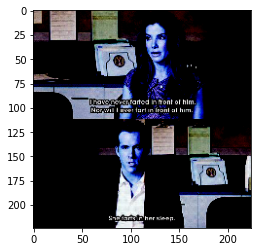

In [37]:
plt.imshow(feat_scaled)

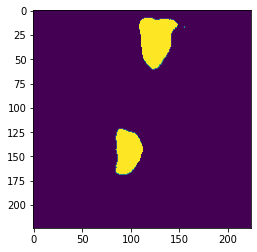

In [38]:
plt.imshow(pred_mask)

Hence, from the above, it can be predicted that the test image has 2 faces.

In [39]:
#part 2


In [40]:
#1.Load the dataset and create the metadata.
# Import the os module
import os

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

# Change the current working directory
os.chdir('/content/drive/MyDrive/greatlearningdata/Projecttrain')

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))



Current working directory: /content
Current working directory: /content/drive/MyDrive/greatlearningdata/Projecttrain


In [41]:
#Extract the zip file [ Score: 2 points ]
from zipfile import ZipFile

projectpath_1 ="/content/drive/MyDrive/greatlearningdata/Projecttrain"
# specifying the zip file name
file_name = "/content/drive/MyDrive/greatlearningdata/Projecttrain/Part 3 - Aligned Face Dataset from Pinterest.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    # zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')


Extracting all the files now...
Done!


In [42]:
#Function to load images
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')


In [43]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [44]:
#Load a sample image [ Score: 2 points ]
load_image("/content/drive/MyDrive/greatlearningdata/Projecttrain/pins/PINS/pins_Aaron Paul/Aaron Paul0_262.jpg")


array([[[233, 188, 165],
        [231, 186, 163],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[232, 187, 164],
        [233, 188, 165],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[230, 186, 161],
        [228, 184, 159],
        [206, 164, 140],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       ...,

       [[198, 118,  91],
        [197, 120,  94],
        [195, 119,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[200, 120,  93],
        [200, 120,  93],
        [198, 121,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[201, 121,  94],
        [201, 121,  94],
        [199, 122,  96],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]]

In [45]:
load_image("/content/drive/MyDrive/greatlearningdata/Projecttrain/pins/PINS/pins_Aaron Paul/Aaron Paul119_219.jpg")

array([[[ 63,  63,  63],
        [ 62,  62,  62],
        [ 69,  69,  69],
        ...,
        [141, 141, 141],
        [141, 141, 141],
        [141, 141, 141]],

       [[ 63,  63,  63],
        [ 62,  62,  62],
        [ 69,  69,  69],
        ...,
        [141, 141, 141],
        [141, 141, 141],
        [140, 140, 140]],

       [[ 63,  63,  63],
        [ 62,  62,  62],
        [ 69,  69,  69],
        ...,
        [141, 141, 141],
        [139, 139, 139],
        [138, 138, 138]],

       ...,

       [[ 44,  44,  44],
        [ 43,  43,  43],
        [ 42,  42,  42],
        ...,
        [196, 196, 196],
        [195, 195, 195],
        [194, 194, 194]],

       [[ 44,  44,  44],
        [ 43,  43,  43],
        [ 43,  43,  43],
        ...,
        [196, 196, 196],
        [195, 195, 195],
        [195, 195, 195]],

       [[ 44,  44,  44],
        [ 43,  43,  43],
        [ 43,  43,  43],
        ...,
        [196, 196, 196],
        [195, 195, 195],
        [195, 195, 195]]

In [46]:
#Load the pre-trained model and weights
#VGG Face model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model


In [47]:
#Load the model [ Score: 2 points ]
model_2=vgg_face()
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [48]:
weights_file = "/content/drive/MyDrive/greatlearningdata/Weights/Part 3 - vgg_face_weights.h5"

In [49]:
# Load VGG Face model weights
model_2.load_weights(weights_file)

In [50]:
#Get vgg_face_descriptor
model_2.layers[0], model_2.layers[-2]

(<keras.layers.convolutional.ZeroPadding2D at 0x7efde5611450>,
 <keras.layers.core.flatten.Flatten at 0x7efcedeb5a90>)

In [51]:
#Generate Embedding vectors for each face in the dataset.
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model_2.layers[0].input, outputs=model_2.layers[-2].output)

In [52]:
type(vgg_face_descriptor)

keras.engine.functional.Functional

In [53]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten')>])

In [54]:
#Generate embeddings for each image in the dataset
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [55]:
embedding_vector[0], type(embedding_vector), type(embedding_vector[0])

(0.03170306, numpy.ndarray, numpy.float32)

In [56]:
embedding_vector[2], embedding_vector[98], embedding_vector[-2]

(-0.012434035, -0.008693833, 0.0021908013)

In [57]:
total_images = len(metadata)

print('total_images :', total_images)

total_images : 10770


In [58]:
#Generate embeddings for all images [ Score: 3 points ]
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img_path1 = metadata[i].image_path()
    img1 = load_image(img_path1)
    img1 = (img1 / 255.).astype(np.float32)
    img1 = cv2.resize(img1, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img1, axis=0))[0]
    embeddings[i]=embedding_vector

In [59]:
print('embeddings shape :', embeddings.shape)

embeddings shape : (10770, 2622)


In [60]:
embeddings[0], embeddings[988], embeddings[988].shape

(array([ 0.03170306, -0.01505131, -0.01243403, ...,  0.0004314 ,
         0.0021908 , -0.00908097]),
 array([-0.00044257,  0.01826   ,  0.01218897, ..., -0.03309941,
         0.01136688,  0.02154326]),
 (2622,))

In [61]:
embeddings[8275]

array([ 0.01786543,  0.00912619,  0.00244407, ..., -0.02196855,
        0.01290168,  0.04220535])

In [62]:
#Build distance metrics for identifying the distance between two given images.
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

Plot images and get distance between the pairs given below
2, 3 and 2, 180
30, 31 and 30, 100
70, 72 and 70, 115

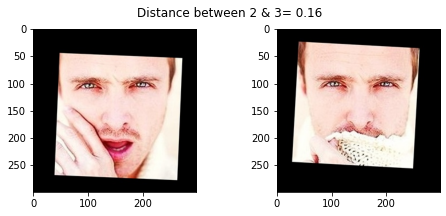

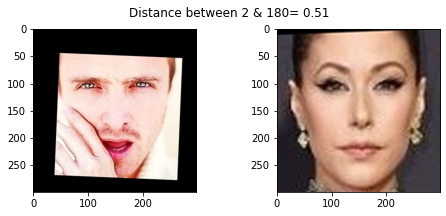

In [63]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# used to supress display of warnings
import warnings

from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

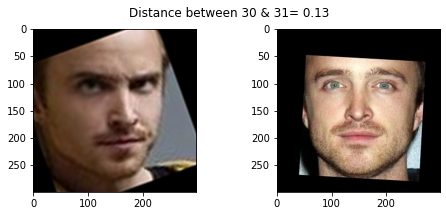

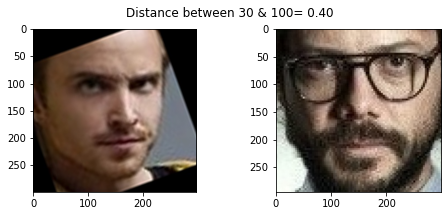

In [64]:
show_pair(30, 31)
show_pair(30, 100)

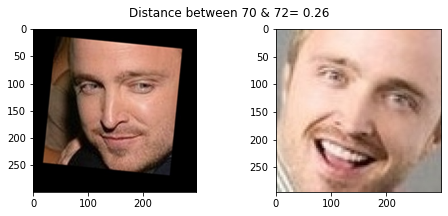

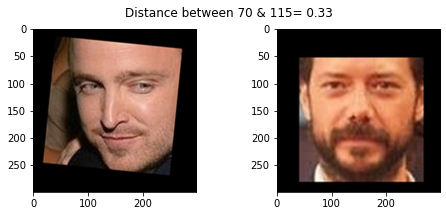

In [65]:
show_pair(70, 72)
show_pair(70, 115)

Create train and test sets [ Score: 2 points ]

Create X_train, X_test and y_train, y_test

Use train_idx to seperate out training features and labels

Use test_idx to seperate out testing features and labels

In [66]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]
targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]

#test labels
y_test = targets[test_idx]

In [67]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (9573,2622)
y_train shape : (9573,)
X_test shape : (1197,2622)
y_test shape : (1197,)


In [68]:
y_test[5], y_train[980]

('pins_Aaron Paul', 'pins_Cameron Monaghan')

In [69]:
#unique test and train values
len(np.unique(y_test)), len(np.unique(y_train))

(100, 100)

Encode the Labels [ Score: 2 points ]

Encode the targets

Use LabelEncoder

In [70]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
print(le.classes_)
y_test_encoded = le.transform(y_test)

['pins_Aaron Paul' 'pins_Alvaro Morte' 'pins_Amanda Crew'
 'pins_Amaury Nolasco' 'pins_Anna Gunn' 'pins_Benedict Cumberbatch'
 'pins_Betsy Brandt' 'pins_Brenton Thwaites' 'pins_Brit Marling'
 'pins_Bryan Cranston' 'pins_Caity Lotz' 'pins_Cameron Monaghan'
 'pins_Chance Perdomo' 'pins_Chris Evans' 'pins_Chris Pratt'
 'pins_Cobie Smulders' 'pins_Danielle Panabaker' 'pins_Dave Franco'
 'pins_Dominic Purcell' 'pins_Dwayne Johnson' 'pins_Emilia Clarke'
 'pins_Emily Bett Rickards' 'pins_Emma Stone' 'pins_Gwyneth Paltrow'
 'pins_Henry Cavil' 'pins_Jason Momoa' 'pins_Jeremy Renner'
 'pins_Jesse Eisenberg' 'pins_Jim Parsons' 'pins_Jon Bernthal'
 'pins_Josh Radnor' 'pins_Kit Harington' 'pins_Krysten Ritter'
 'pins_Kumail Nanjiani' 'pins_Maisie Williams' 'pins_Mark Ruffalo'
 'pins_Martin Starr' 'pins_Melissa benoit' 'pins_Mike Colter'
 'pins_Morena Baccarin' 'pins_Morgan Freeman' 'pins_Natalie Portman '
 'pins_Neil Patrick Harris' 'pins_Paul Rudd' 'pins_Pedro Alonso'
 'pins_Peter Dinklage' 'pins_

In [71]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [ 0  0  0 ... 99 99 99]
y_test_encoded :  [ 0  0  0 ... 99 99 99]


Standardize the feature values [ Score: 2 points ]

Scale the features using StandardScaler

In [72]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

Reduce dimensions using PCA (3 marks)

Reduce feature dimensions using Principal Component Analysis

Set the parameter n_components=128

In [73]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [74]:
#Build an SVM classi!ier in order to map each image to its right person.

Build a Classifier (3 marks)

Use SVM Classifier to predict the person in the given image

Fit the classifier and print the score

In [75]:
from sklearn.svm import SVC

svm = SVC(C=5., gamma=0.001)
svm.fit(X_train_pca, y_train_encoded)

SVC(C=5.0, gamma=0.001)

In [76]:
#prediction and accuracy of the model on test data
y_predicted = svm.predict(X_test_pca)


In [77]:
print('y_predicted : ',y_predicted)
print('y_test_encoded : ',y_test_encoded)

y_predicted :  [ 0  0  0 ... 99 99 99]
y_test_encoded :  [ 0  0  0 ... 99 99 99]


In [78]:
#transforming y_predicted variable
y_pred_encoded = le.inverse_transform(y_predicted)

In [79]:
#print y_pred_encoded
print('y_pred_encoded : ',y_pred_encoded)

y_pred_encoded :  ['pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' ... 'pins_zendaya'
 'pins_zendaya' 'pins_zendaya']


In [80]:
#shape of the y_predicted and encoded shape
print('y_predicted shape : ', y_predicted.shape)
print('y_test_encoded shape : ', y_test_encoded.shape)

y_predicted shape :  (1197,)
y_test_encoded shape :  (1197,)


In [81]:
# Find the classification accuracy
Accuracy=accuracy_score(y_test_encoded, y_predicted)
print("The Accuracy of the SVM model:",Accuracy)

The Accuracy of the SVM model: 0.9507101086048454


Test results (2 marks)

Take 10th image from test set and plot the image

Report to which person(folder name in dataset) the image belongs to

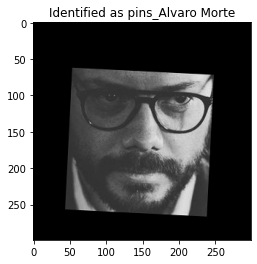

In [82]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction =y_predicted[example_idx]
example_identity = y_pred_encoded[example_idx]
plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

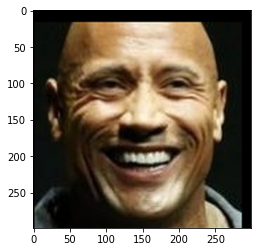

In [83]:
#Import the the test image. Display the image. Use the SVM trained model to predict the face.
testimage = '/content/drive/MyDrive/greatlearningdata/Projecttrain/test1/Dwayne+Johnson4.jpg'

# load image from file
image = plt.imread(testimage)
plt.imshow(image)

In [90]:
#prediction with SVM

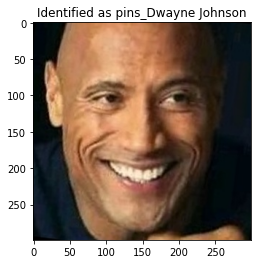

In [84]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 221

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction =y_predicted[example_idx]
example_identity = y_pred_encoded[example_idx]
plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

From, above it can be determined that the SVm model has predicted the dwayne johnson test image correctly.

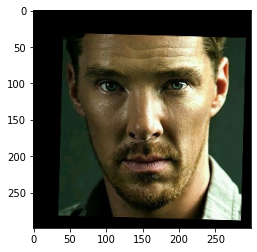

In [89]:
#Import the the test image. Display the image. Use the SVM trained model to predict the face.
testimage1 = '/content/drive/MyDrive/greatlearningdata/Projecttrain/Benedict+Cumberbatch9.jpg'

# load image from file
image2 = plt.imread(testimage1)
plt.imshow(image2)

In [91]:
#prediction with SVM

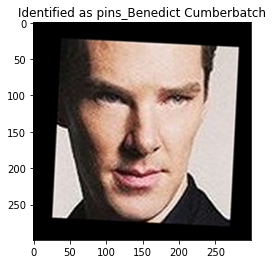

In [116]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 54
example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction =y_predicted[example_idx]
example_identity = y_pred_encoded[example_idx]
plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

From, above it can be determined that the SVm model has predicted the benedict cumberbatch test image correctly.